## Setup

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras

2022-10-07 17:39:00.848513: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 17:39:00.927561: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-07 17:39:00.930402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-07 17:39:00.930411: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [2]:
# Functions for the field calculations

def mag(x):
    """Calculates magnitude of vector x"""
    return np.sqrt(np.dot(x,x))

def dipole_field(r, r0, m, a):
    """
    Calculates magnetic field of a single dipole
    r - location of the field
    r0 - position of the dipole
    m - magnitude of the dipole. Negative values correspond to the opposite orientation of  the dipole axis
    a - dipole axis"""
    M = m*a   # Magnetic moment vector
    R = r-r0
    if np.dot(R,R) == 0: #This one is to avoid singularities
        return np.array([0, 0, 0])
    return mu0*(3*R*(np.dot(M,R))/(mag(R)**5) - M/(mag(R)**3))

def total_field(r, m_array: np.array, dipole_axis: np.array) -> np.array:
    """Calculates the total field at point r
    To simplify the data set generation later, the magnitudes of the three dipoles are placed in array m.
    B0 is the external field.
    dipole_axis is the dipole orientation (same for all three)"""
    B1 = dipole_field(r, R1, m_array[0], dipole_axis)
    B2 = dipole_field(r, R2, m_array[1], dipole_axis)
    B3 = dipole_field(r, R3, m_array[2], dipole_axis)
    return B1+B2+B3

In [3]:
# Constants and the setup parameters

mu0 = 10**-7# magnetic constant
m = 1e8 # Scaling factor magnetic dipole magnitude

# Magnetic dipole position vectors
R1 = np.array([1, 0, 1])
R2 = np.array([-np.cos(np.pi/3), np.sin(np.pi/3), 1])
R3 = np.array([-np.cos(np.pi/3), -np.sin(np.pi/3), 1])

# Magnetic dipole orientation (same for all three)
A = np.array([0, 0, 1]) # It is a global variable

# The magnetometer location. Magnetic field is calculated here
r0 = np.array([0., 0., 0.])

## Test
We'll test on a field rotating around y-axis

In [4]:
# Generate test field

# Rotation angle
theta = np.linspace(0, 4*np.pi, 151)
B_test = []

for th in theta:
    B_test.append(1 * np.array([np.sin(th), 0, np.cos(th)]))

B_test = np.array(B_test)

### Linear

In [5]:
M_ = np.loadtxt("data/lin_cal_mat.csv")
print(M_)

[[ 1.25707872e-01 -3.39218910e-18  1.88561808e-01]
 [-6.28539361e-02  1.08866211e-01  1.88561808e-01]
 [-6.28539361e-02 -1.08866211e-01  1.88561808e-01]]


In [6]:
V_test = []
B_predict = []
for B in B_test:
    V = np.dot(M_, B)
    V_test.append(V)
    B_predict.append(total_field(r0, V * m, A))

B_predict = np.array(B_predict)

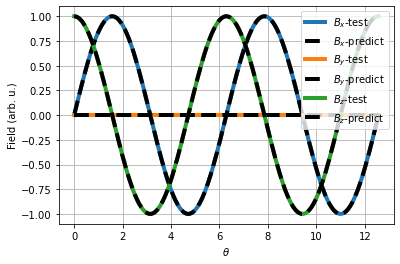

In [7]:
# Plot
fig, ax = plt.subplots()
ax.plot(theta, B_test[:,0], label=r'$B_x$-test', linewidth=4.0)
ax.plot(theta, B_predict[:,0], label=r'$B_x$-predict', linewidth=4.0, color='black', ls='--')

ax.plot(theta, B_test[:,1], label=r'$B_y$-test', linewidth=4.0)
ax.plot(theta, B_predict[:,1], label=r'$B_y$-predict', linewidth=4.0, color='black', ls='--')

ax.plot(theta, B_test[:,2], label=r'$B_z$-test', linewidth=4.0)
ax.plot(theta, B_predict[:,2], label=r'$B_z$-predict', linewidth=4.0, color='black', ls='--')

ax.set_xlabel(r'$\theta$')
ax.set_ylabel('Field (arb. u.)' )
#ax.set_xlim(0,1)
ax.legend(loc=0)
ax.grid()